In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from datetime import date
from datetime import datetime

In [8]:
def agg_string_to_arr(arr):
    new_arr = []
    for e in arr:
        if e not in new_arr:
            new_arr.append(e)
    return new_arr

def attendance_demog_wash_by_child(attendance, demog):
    #-explain
    
    #CSV -> DF
    attendance_df = pd.read_csv(attendance)
    demog_df = pd.read_csv(demog)
    
    #ATTENDANCE
    #----------
    
    #Extrapolate attendance specifier as boolean columns
    one_hot_atten = pd.get_dummies(attendance_df['Attendance'])
    one_hot_sesh = pd.get_dummies(attendance_df['Session'])
    attendance_clean = attendance_df.join(one_hot_atten)
    attendance_clean = attendance_clean.join(one_hot_sesh)
    
    #Combine rows by ChildID and 
    attendance_clean = attendance_clean.groupby(['ChildID'],as_index=False).agg(
             {'Best Interest': 'sum',
              'In Attendance': 'sum',
              'Other': 'sum',
              'Sick':'sum',
              'Unexcused Absence':'sum',
              'FD':'sum',
              'PD':'sum',
              'Center':agg_string_to_arr})
    
    #Add aggregate columns: Total Attendance,Absence, and Days AND Attendance Rate
    attendance_clean['Total Attendance'] = attendance_clean['In Attendance']
    attendance_clean['Total Absence'] = attendance_clean['Other'] + attendance_clean['Sick'] + attendance_clean['Unexcused Absence'] + attendance_clean['Best Interest']
    attendance_clean['Total Days'] = attendance_clean['Total Attendance'] + attendance_clean['Total Absence']
    attendance_clean['Attendance Rate'] = attendance_clean['Total Attendance'] / attendance_clean['Total Days']
    
    attendance_clean_final = attendance_clean
    
    #DEMOGRAPHICS
    #------------
    
    #Reorder Columns
    demog_clean = demog_df[['ChildID','ChildEthnicity','ChildRace','ChildLanguage','ChildFlags','ChildDateofBirth']]
    
    #Drop NAN 
    demog_clean = demog_clean[demog_clean['ChildDateofBirth'].notna()]

    #Add current age column
    today = datetime.today() 

    def get_age(bday_str):
        datetime_bday = datetime.strptime(str(bday_str),"%m/%d/%Y")
        age = (today-datetime_bday).days // 365
        return age

    demog_clean['Age (as of current day)'] = demog_clean['ChildDateofBirth'].apply(get_age)
    
    #Make ID# an int
    demog_clean['ChildID'] = demog_clean.ChildID.astype(int)
    
    #Aggregate rows to combine duplicate ChildIDs
    
    #Df with only aggregated string columns
    combined_str = demog_clean.groupby('ChildID').agg({'ChildRace':agg_string_to_arr, 'ChildFlags':agg_string_to_arr})
    
    #Combine agg str with demog clean
    merged = combined_str.merge(demog_clean, on = 'ChildID',how = 'left')
    
    #Drop extraneous columns 
    cleaned = merged[['ChildID','ChildEthnicity','ChildLanguage','ChildRace_x','ChildFlags_x','ChildDateofBirth','Age (as of current day)']]
    
    #Drop duplicates rows
    demog_clean_final = cleaned.drop_duplicates(subset= 'ChildID')
    
    #Rename columns
    demog_clean_final = demog_clean_final.rename(columns = {"ChildRace_x":'ChildRace',"ChildFlags_x":'ChildFlags'})
    
    
    #JOIN DFs for MASTER
    master = pd.merge(demog_clean_final,attendance_clean_final, how='inner', on= 'ChildID')
    
    #EXPORT
    #------
    from pathlib import Path 

    filepath = Path(attendance[:-4] + 'CHILDID_out.csv')  
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    master.to_csv(filepath)
    
    return master

df = attendance_demog_wash_by_child('18-19 attendance master.csv','PvH-demographicsdash_childdata.csv')
df


,ChildID,ChildEthnicity,ChildLanguage,ChildRace,ChildFlags,ChildDateofBirth,Age (as of current day),Best Interest,In Attendance,Other,Sick,Unexcused Absence,FD,PD,Center,Total Attendance,Total Absence,Total Days,Attendance Rate
0,18578,Hispanic or Latino,01 -- Spanish,[Caucasian],[Preschool],12/28/2004,17,0,102.0,0,0,0,102.0,0,[FH],102.0,0,102.0,1.000000
1,22717,Hispanic or Latino,01 -- Spanish,[Caucasian],[Infant/Toddler],01/13/2008,14,0,245.0,2,1,0,248.0,0,[FH],245.0,3,248.0,0.987903
2,25173,Hispanic or Latino,00 -- English,[Caucasian],[Preschool],01/06/2007,15,0,242.0,2,4,0,248.0,0,[FH],242.0,6,248.0,0.975806
3,30829,Hispanic or Latino,01 -- Spanish,[Caucasian],[Infant/Toddler],11/19/2010,11,0,246.0,2,0,0,248.0,0,[FH],246.0,2,248.0,0.991935
4,31583,Hispanic or Latino,00 -- English,[Caucasian],[Emergency Care],05/22/2010,12,3,232.0,1,10,0,246.0,0,[Linda Vista],232.0,14,246.0,0.943089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4781,65271,Not Hispanic or Latino,00 -- English,[Caucasian],"[Admissions Agreement #15 (check box if Yes), ...",03/06/2015,7,0,2.0,0,0,0,0.0,2,[Emerald Vista],2.0,0,2.0,1.000000
4782,65289,Not Hispanic or Latino,00 -- English,[Caucasian],[nan],08/15/2016,6,0,1.0,0,0,0,1.0,0,[Esther Hobbs],1.0,0,1.0,1.000000
4783,65290,Hispanic or Latino,00 -- English,[nan],"[Shelter-In-Place, IFSP]",11/14/2017,4,0,3.0,0,0,0,3.0,0,[Esther Hobbs],3.0,0,3.0,1.000000
4784,65301,Hispanic or Latino,01 -- Spanish,[Caucasian],"[IEP, Admissions Agreement #16 (check box if Y...",05/12/2016,6,0,1.0,0,0,0,1.0,0,[Castlemont],1.0,0,1.0,1.000000


In [17]:
def attendance_demog_wash_by_center(attendance, demog):
    #-explain
    
    #CSV -> DF
    attendance_df = pd.read_csv(attendance)
    demog_df = pd.read_csv(demog)
    
    #ATTENDANCE
    #----------
    
    #Extrapolate attendance specifier as boolean columns
    one_hot_atten = pd.get_dummies(attendance_df['Attendance'])
    one_hot_sesh = pd.get_dummies(attendance_df['Session'])
    attendance_clean = attendance_df.join(one_hot_atten)
    attendance_clean = attendance_clean.join(one_hot_sesh)
    
    #Combine rows by ChildID and 
    attendance_clean = attendance_clean.groupby(['ChildID','Center'],as_index=False).agg(
             {'Best Interest': 'sum',
              'In Attendance': 'sum',
              'Other': 'sum',
              'Sick':'sum',
              'Unexcused Absence':'sum',
              'FD':'sum',
              'PD':'sum'})
    
    #Add aggregate columns: Total Attendance,Absence, and Days AND Attendance Rate
    attendance_clean['Total Attendance'] = attendance_clean['In Attendance']
    attendance_clean['Total Absence'] = attendance_clean['Other'] + attendance_clean['Sick'] + attendance_clean['Unexcused Absence'] + attendance_clean['Best Interest']
    attendance_clean['Total Days'] = attendance_clean['Total Attendance'] + attendance_clean['Total Absence']
    attendance_clean['Attendance Rate'] = attendance_clean['Total Attendance'] / attendance_clean['Total Days']
    
    attendance_clean_final = attendance_clean
    
    #DEMOGRAPHICS
    #------------
    
    #Reorder Columns
    demog_clean = demog_df[['ChildID','ChildEthnicity','ChildRace','ChildLanguage','ChildFlags','ChildDateofBirth']]
    
    #Drop NAN 
    demog_clean = demog_clean[demog_clean['ChildDateofBirth'].notna()]

    #Add current age column
    today = datetime.today() 

    def get_age(bday_str):
        datetime_bday = datetime.strptime(str(bday_str),"%m/%d/%Y")
        age = (today-datetime_bday).days // 365
        return age

    demog_clean['Age (as of current day)'] = demog_clean['ChildDateofBirth'].apply(get_age)
    
    #Make ID# an int
    demog_clean['ChildID'] = demog_clean.ChildID.astype(int)
    
    #Aggregate rows to combine duplicate ChildIDs
    
    #Df with only aggregated string columns
    combined_str = demog_clean.groupby('ChildID').agg({'ChildRace':agg_string_to_arr, 'ChildFlags':agg_string_to_arr})
    
    #Combine agg str with demog clean
    merged = combined_str.merge(demog_clean, on = 'ChildID',how = 'left')
    
    #Drop extraneous columns 
    cleaned = merged[['ChildID','ChildEthnicity','ChildLanguage','ChildRace_x','ChildFlags_x','ChildDateofBirth','Age (as of current day)']]
    
    #Drop duplicates rows
    demog_clean_final = cleaned.drop_duplicates(subset= 'ChildID')
    
    #Rename columns
    demog_clean_final = demog_clean_final.rename(columns = {"ChildRace_x":'ChildRace',"ChildFlags_x":'ChildFlags'})
    
    
    #JOIN DFs for MASTER
    master = pd.merge(demog_clean_final,attendance_clean_final, how='inner', on= 'ChildID')
    
    #EXPORT
    #------
    from pathlib import Path 

    filepath = Path(attendance[:-4] + 'CENTER_out.csv')  
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    master.to_csv(filepath)
    
    return master


Decoto                   191
Cesar Chavez             179
Linda Vista              157
Arbuckle                 156
Amador                   149
Emerald Vista            145
Paul Miller              144
Holbrook                 144
Baldwin Park             140
FH                       137
Eden Youth               131
Cureton                  118
Educare                  115
Valley Medical Center    113
Hubbard                  111
Esther Hobbs             106
Castlemont               105
Sharon Jones             102
Graham                    95
Royal Sunset              94
Schilling                 94
Washington Hospital       94
Russo                     93
Del Rey                   91
Dorsa                     90
Logan                     90
Meadowfair                88
Colonial Acres            88
Meyer                     86
Eden Palms                85
Hesperian                 83
Grant                     81
Dayton                    80
Hillview                  80
Cox           

In [ ]:
center_df =attendance_demog_wash_by_center('18-19 attendance master.csv','PvH-demographicsdash_childdata.csv')
center_df['Center'].value_counts().head()

<AxesSubplot:xlabel='Center', ylabel='Attendance Rate'>

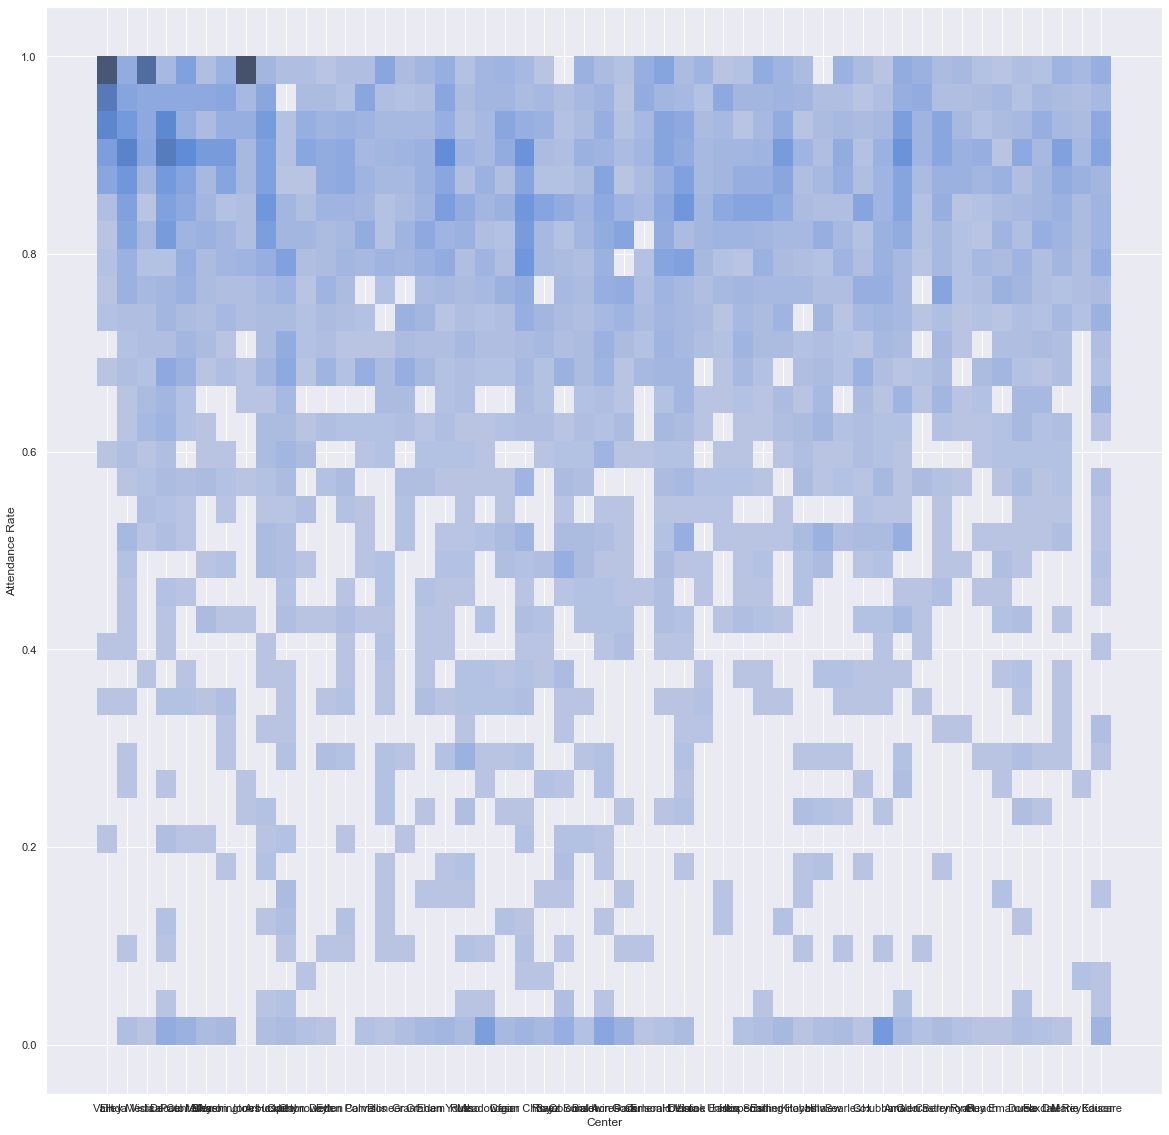

In [15]:
sns.set(rc={"figure.figsize":(20, 20)})
sns.histplot(data = center_df, x = 'Center', y = 'Attendance Rate')